# Working with spiking JAX layers

In [15]:
## Housekeeping and imports

# - Numpy
import numpy as np

# - Matplotlib and plotting config
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]

# - Switch off warnings
import warnings
warnings.filterwarnings('ignore')

## Available layers

## Layer dynamics
The membrane and synaptic dynamics evolve under the equations

$$\tau_{syn} \dot{I}_{syn} + I_{syn} = 0$$
$$\tau_{mem} \dot{V}_{mem} + V_{mem} = I_{syn} + I_{in}(t)\cdot W_{in} + b + \sigma\zeta(t)$$
$$I_{syn} = I_{syn} + S_{in}(t) \cdot W_{in}$$

where $I_{syn}$ is the $N$ vector of synaptic input currents; $V_{mem}$ is the $N$ vector of membrane potentials of the neurons; $b$ is the $N$ vector of bias currents; $\sigma\zeta(t)$ is a white noise process with standard deviation $\sigma$, injected independently into each neuron; $\tau_{syn}$ and $\tau_{mem}$ are the $N$ vectors of synaptic and membrane time constants, respectively; and $W_{in}$ is the $[N_{in} \times N]$ input weight matrix.

The input spike train $S_{in}(t)$ is $1$ when a spike is present on an input channel. When an input spike arrives on an input channel, the synaptic current variable is incremented by $1$ then decays to zero.

The input currents $I_{in}(t)$ define input channels injeted onto neuron membranes via the input weight matrix $W_{in}$.

### Spiking
When the membrane potential for neuron $j$, $V_{mem, j}$ exceeds the threshold voltage $V_{thr} = 0$, then the neuron $j$ emits a spike. These events are collected into the binary spike variable $S_{rec}(t)$.

$$S_{rec}(t) = H(V_{mem} - V_{thr})$$
$$I_{syn} = I_{syn} + S_{rec}(t) \cdot W_{rec}$$
$$V_{mem} = V_{mem} - S_{rec}(t)$$

Where $H(x)$ is a Heaviside function for spike production (with a pseudo gradient described below), $H(x) = x > 0$; and $W_{rec}$ is the matrix of recurrent synaptic weights.

All neurons therefore share a common resting potential of `0`, a firing threshold of `0`, and a subtractive reset of `-1`. The bias current for each neuron is set to `-1` by default.

The spiking events emitted by the layer $S_{rec}(t)$ are returned as the output of the

### Surrogate signals for back-propagation
To assist with training, the layers describe here use surrogate signals in two ways:
 - To generate a non-spiking weighted output from $V_{mem}$, which can be used to train the layer to approximate a target representation
 - On spike generation via $H(x)$, used to propagate errors backwards through time
 
A surrogate $U(t)$ is generated from the layer, with $U(t) = \textrm{sig}\left[V_{mem}(t)\right]$, where $\textrm{sig}(x)$ is the sigmoid function $\textrm{sig}(x) = \left[1 + \exp(x)\right]^{-1}$. The surrogate weighted output of a layer is given by

$$O(t) = U(t) \cdot W_{out}$$

Where $W_{out}$ is the $[N \times N_{out}]$ output weight matrix.
 
$H(x)$ is implemented internally such that it becomes differentiable in the backwards pass.

* Forward pass: $H(x) = \max\left[0, \textrm{floor}(x + 1)\right]$. This form permits multiple events for each neuron per time step.
* Backwards pass: $\textrm{d}H(x)/\textrm{d}x = (x > -0.5)$

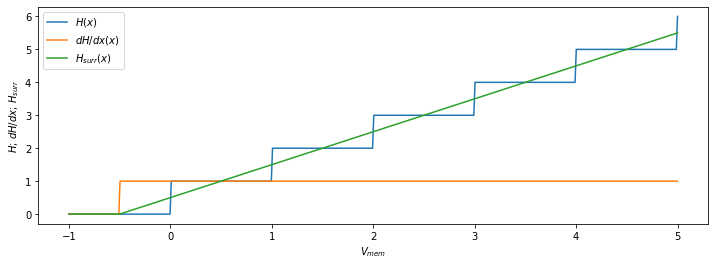

In [16]:
def H(x):
    return np.clip(np.floor(x + 1.0), 0.0, np.inf)

def dHdx(x):
    return x > -0.5

def H_surrogate(x):
    return np.clip(x+.5, 0.0, np.inf)

x = np.linspace(-1., 5., 500)

plt.figure()
plt.plot(x, H(x), x, dHdx(x), x, H_surrogate(x))
plt.legend(['$H(x)$', '$dH/dx(x)$', '$H_{surr}(x)$'])
plt.xlabel('$V_{mem}$')
plt.ylabel('$H$; $dH/dx$; $H_{surr}$');

In other words, $\textrm{d}H(x)/\textrm{d}x(x)$ acts as though each neuron is a linear-threshold unit.

### Spiking versus current inputs

### Spiking versus surrogate outputs

## Building and simulating a spiking recurrent layer

In [17]:
## -- Import the recurrent layer
from rockpool.layers import RecLIFJax
from rockpool import TSEvent, TSContinuous

In [18]:
# - Build a recurrent layer
num_neurons = 100
bias = -1
dt = 1e-3

weights_rec = 1 * np.random.randn(num_neurons, num_neurons) / np.sqrt(num_neurons)
tau_mem = np.random.rand(num_neurons) * 100e-3 + 50e-3
tau_syn = np.random.rand(num_neurons) * 100e-3 + 50e-3

lyrLIF = RecLIFJax(weights_rec, tau_mem, tau_syn, bias, 
                   name = 'Recurrent LIF layer', dt = dt)
print(lyrLIF)

RecLIFJax object: "Recurrent LIF layer" [100 TSEvent in -> 100 internal -> 100 TSEvent out]


We'll generate a Poisson input signal independently for each of the layer neurons, with a sinusoidal modulation.

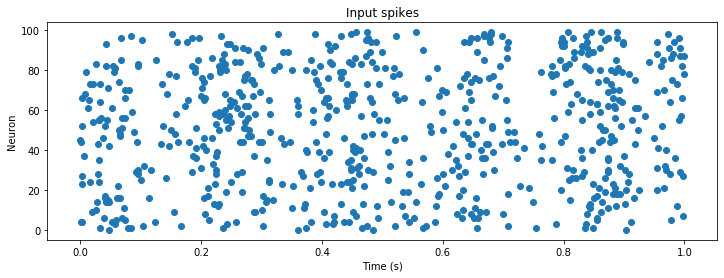

In [19]:
# - Build an input signal
input_duration = 1.
mod_freq = 5.
min_rate = 3.
max_rate = 10.

# - Generate a sinusoidal instantaneous rate
time_base = np.arange(0, input_duration, dt)
sinusoid = (np.sin(time_base * 2*np.pi * mod_freq)/2. + .5) * (max_rate - min_rate) + min_rate
sinusoid_ts = TSContinuous(time_base, sinusoid)

# - Generate Poisson spiking inputs
raster = np.random.rand(len(time_base), num_neurons) < np.tile(sinusoid * dt, (num_neurons, 1)).T
spikes = np.argwhere(raster)
input_sp_ts = TSEvent(time_base[spikes[:, 0]], spikes[:, 1],
                      t_start = 0., t_stop = input_duration,
                      name = "Input spikes",
                      periodic = True,
                     )

# - Plot the input events
plt.figure()
input_sp_ts.plot()
plt.ylabel('Neuron');

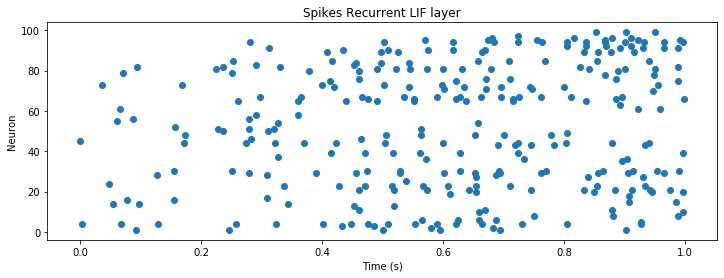

In [20]:
# - Evolve the layer with the input events
output_ts = lyrLIF.evolve(input_sp_ts)

# - Plot the output events
plt.figure()
output_ts.plot()
plt.ylabel('Neuron');

As described above, several other properties are set on each evolution, to assist in monitoring the behaviour of the layers. Let's plot those and take a look.

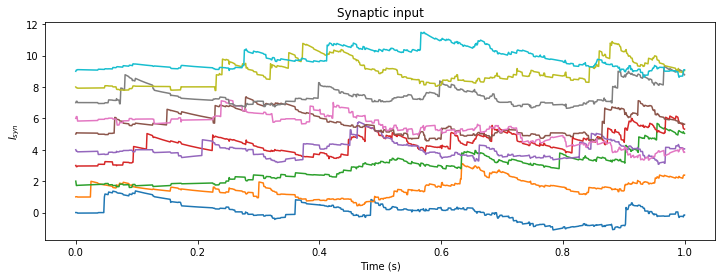

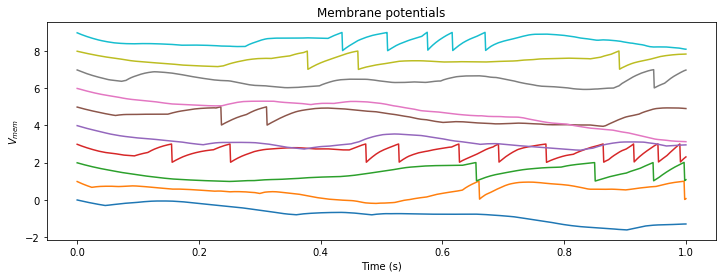

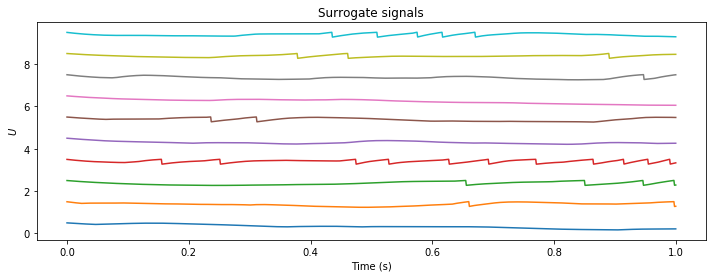

In [21]:
# - Synaptic input currents
plt.figure()
lyrLIF.i_syn_last_evolution.plot(stagger = 1, skip = 10);
plt.xlabel('Time (s)')
plt.ylabel('$I_{syn}$')
plt.title('Synaptic input');

# - Membrane potentials
plt.figure()
lyrLIF.v_mem_last_evolution.plot(stagger = 1, skip = 10);
plt.xlabel('Time (s)')
plt.ylabel('$V_{mem}$')
plt.title('Membrane potentials');

# - Surrogate signals
plt.figure()
lyrLIF.surrogate_last_evolution.plot(stagger = 1, skip = 10);
plt.xlabel('Time (s)')
plt.ylabel('$U$')
plt.title('Surrogate signals');


## Building and stimulating a layer with current injection inputs

In [22]:
# - Import a current-in class
from rockpool.layers import RecLIFCurrentInJax

# - Create a current-injection layer
lyrCI = RecLIFCurrentInJax(weights_rec, tau_mem, tau_syn,
                           name = 'Recurrent LIF layer - CI', dt = dt)
print(lyrCI)

RecLIFCurrentInJax object: "Recurrent LIF layer - CI" [100 TSContinuous in -> 100 internal -> 100 TSEvent out]


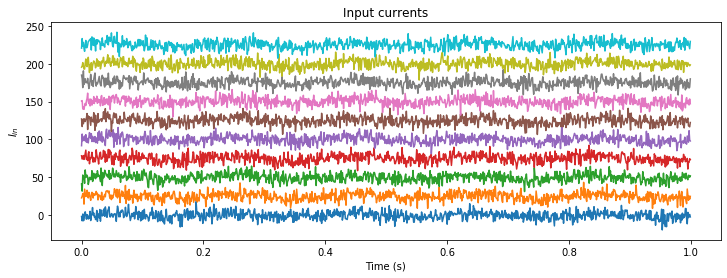

In [23]:
# - Generate several noisy sinusoids as input currents
input_duration = 1.
mod_freq = 5.
sin_amp = 5.
noise_std = 5.

# - Generate a sinusoidal signal
time_base = np.arange(0, input_duration, dt)
sinusoid = sin_amp * np.sin(time_base * 2*np.pi * mod_freq) / 2.

inputs = np.tile(sinusoid, (num_neurons, 1)).T + noise_std * np.random.randn(len(time_base), num_neurons)
input_ts = TSContinuous(time_base, inputs, periodic = True,
                        name = "Input currents",
                        units = "$I_{in}$",
                       )

# - Plot the input currents
plt.figure()
input_ts.plot(stagger = noise_std * sin_amp, skip = 10);

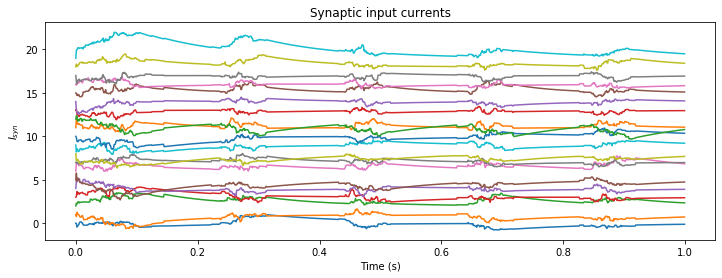

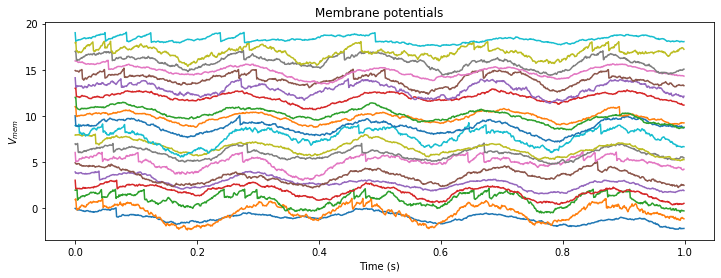

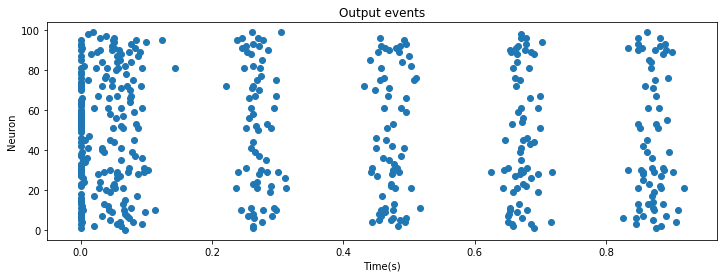

In [24]:
# - Evolve the layer
lyrCI.evolve(input_ts)

# - Display the layer activity
plt.figure()
lyrCI.i_syn_last_evolution.plot(stagger = 1, skip = 5)
plt.ylabel('$I_{syn}$')
plt.title('Synaptic input currents')

plt.figure()
lyrCI.v_mem_last_evolution.plot(stagger = 1, skip = 5);
plt.ylabel('$V_{mem}$')
plt.title('Membrane potentials')

plt.figure()
lyrCI.spikes_last_evolution.plot();
plt.ylabel('Neuron')
plt.title('Output events')
plt.xlabel('Time(s)');

## Using layers with input / output weighting

In [25]:
# - Import a weighted layer
from rockpool.layers import RecLIFJax_IO

# - Build a layer with weighted inputs and outputs
num_in = 2
num_out = 5

w_in = np.random.rand(num_in, num_neurons)
w_rec = 1.1 * np.random.randn(num_neurons, num_neurons) / np.sqrt(num_neurons)
w_out = np.random.rand(num_neurons, num_out)

lyrIO = RecLIFJax_IO(w_in, w_rec, w_out,
                     tau_mem, tau_syn,
                     name = 'LIF with I/O weighting',
                     dt = dt,
                    )
print(lyrIO)

RecLIFJax_IO object: "LIF with I/O weighting" [2 TSEvent in -> 100 internal -> 5 TSContinuous out]


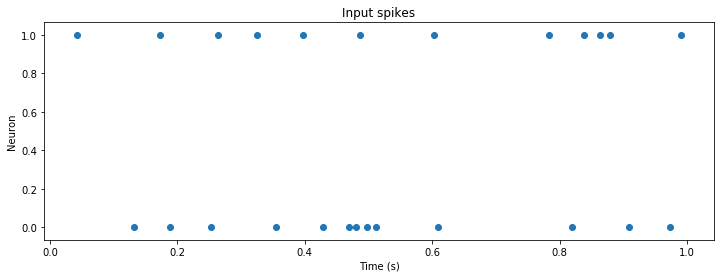

In [26]:
# - Build an input signal
input_duration = 1.
mod_freq = 5.
min_rate = 10.
max_rate = 20.

# - Generate a sinusoidal instantaneous rate
time_base = np.arange(0, input_duration, dt)
sinusoid = (np.sin(time_base * 2*np.pi * mod_freq)/2. + .5) * (max_rate - min_rate) + min_rate
sinusoid_ts = TSContinuous(time_base, sinusoid)

# - Generate Poisson spiking inputs
raster = np.random.rand(len(time_base), num_in) < np.tile(sinusoid * dt, (num_in, 1)).T
spikes = np.argwhere(raster)
input_sp_ts = TSEvent(time_base[spikes[:, 0]], spikes[:, 1],
                      t_start = 0., t_stop = input_duration,
                      periodic = True,
                      name = "Input spikes",
                     )

# - Plot the input events
plt.figure()
input_sp_ts.plot()
plt.ylabel('Neuron');

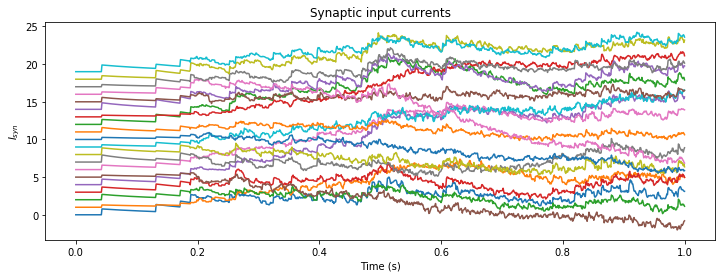

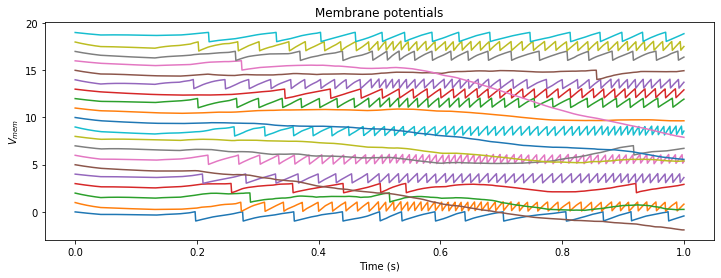

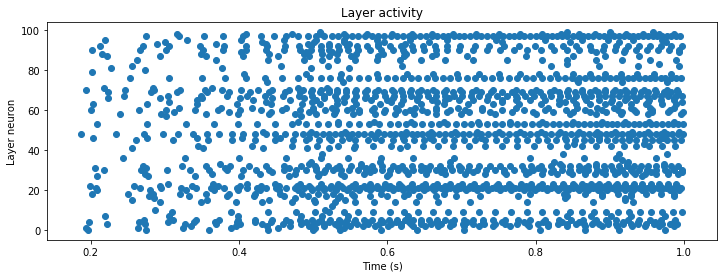

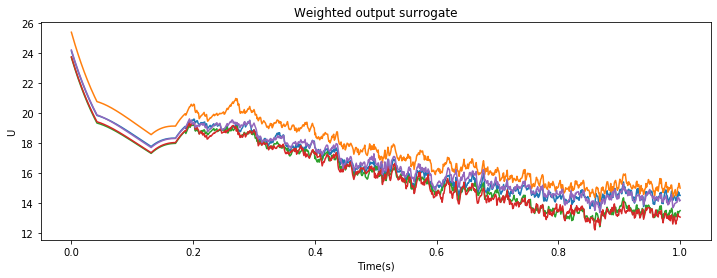

In [27]:
# - Evolve the layer
output_ts = lyrIO.evolve(input_sp_ts)

# - Plot layer activity
plt.figure()
lyrIO.i_syn_last_evolution.plot(stagger = 1, skip = 5);
plt.ylabel('$I_{syn}$')
plt.title('Synaptic input currents')

plt.figure()
lyrIO.v_mem_last_evolution.plot(stagger = 1, skip = 5);
plt.ylabel('$V_{mem}$')
plt.title('Membrane potentials')

plt.figure()
lyrIO.spikes_last_evolution.plot()
plt.ylabel('Layer neuron')
plt.title('Layer activity')

plt.figure()
output_ts.plot()
plt.xlabel('Time(s)')
plt.ylabel('U')
plt.title('Weighted output surrogate');

## Using JAX to perform gradient-based learning
To be continued...